In [1]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Concatenate, Lambda, Flatten, Dense, BatchNormalization, MaxPooling2D, AveragePooling2D, Layer
from tensorflow.keras.initializers import glorot_uniform
# from tensorflow.keras.engine.topology import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import skimage as sk
import time

from facerecog_utils import *
from inception_blocks import *
from database_utils import *
from align import AlignDlib

C:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


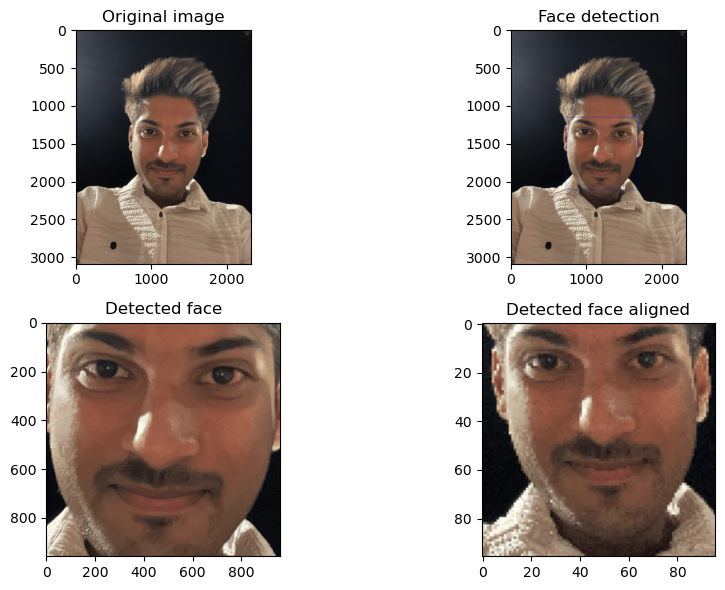

In [2]:
#----------------- Face detection and alignment -----------------#
alignment = AlignDlib('Libraries/landmarks.dat')

img_path = 'Database/Udit_Sethi/Udit_001.png'
img_orig = import_image(img_path)
face_list, face_pos, img_face = get_faces_from_image(img_orig, plot=False)
this_face = face_list[0]
this_face_align = face_aligned(img_orig)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(221)
ax1.set_title('Original image')
plt.imshow(img_orig)
ax2 = fig.add_subplot(222)
ax2.set_title('Face detection')
plt.imshow(img_face)
ax3 = fig.add_subplot(223)
ax3.set_title('Detected face')
plt.imshow(this_face)
ax4 = fig.add_subplot(224)
ax4.set_title('Detected face aligned')
plt.imshow(this_face_align)
plt.tight_layout()

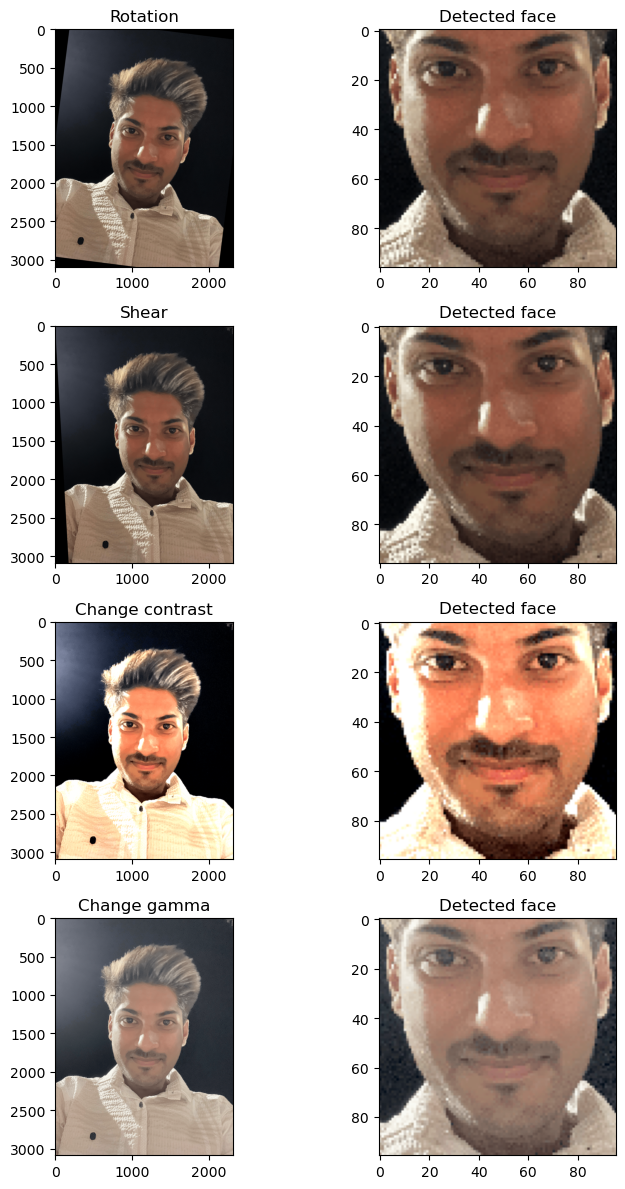

In [3]:
#------------------- Data augmentation---------------------#
img_path = 'Database/Udit_Sethi/Udit_001.png'
img_orig = import_image(img_path)

img_rotate = random_rotate(img_orig)
img_shear = random_shear(img_orig)
img_contrast = change_contrast(img_orig, percent_change=(10,20))
img_gamma = gamma_correction(img_orig,gamma_range=(0.5,0.6))

fig = plt.figure(figsize=(8,12))

ax1 = fig.add_subplot(421)
ax1.set_title('Rotation')
plt.imshow(img_rotate)
ax2 = fig.add_subplot(422)
ax2.set_title('Detected face')
plt.imshow(face_aligned(img_rotate))

ax3 = fig.add_subplot(423)
ax3.set_title('Shear')
plt.imshow(img_shear)
ax4 = fig.add_subplot(424)
ax4.set_title('Detected face')
plt.imshow(face_aligned(img_shear))

ax5 = fig.add_subplot(425)
ax5.set_title('Change contrast')
plt.imshow(img_contrast)
ax6 = fig.add_subplot(426)
ax6.set_title('Detected face')
plt.imshow(face_aligned(img_contrast))

ax7 = fig.add_subplot(427)
ax7.set_title('Change gamma')
plt.imshow(img_gamma)
ax8 = fig.add_subplot(428)
ax8.set_title('Detected face')
plt.imshow(face_aligned(img_gamma))

plt.tight_layout()

Model: "FaceRecoModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3, 96, 96) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 3, 102,    │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 102)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 64, 48,    │      9,472 │ zero_padding2d[0… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 64, 48,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 48,    │          0 │ bn1[0][0]         │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 64, 50,    │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 24,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 64, 24,    │      4,160 │ max_pooling2d[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 64, 24,    │        256 │ conv2[0][0]       │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 24,    │          0 │ bn2[0][0]         │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 64, 26,    │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 192, 24,   │    110,784 │ zero_padding2d_2… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 192, 24,   │        768 │ conv3[0][0]       │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 192, 24,   │          0 │ bn3[0][0]         │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 192, 26,   │          0 │ activation_2[0][… │
│ (ZeroPadding2D)     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 192, 12,   │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_3x3_c… │ (None, 96, 12,    │     18,528 │ max_pooling2d_1[

 Total params: 3,743,280 (14.28 MB)

 Trainable params: 3,733,968 (14.24 MB)

 Non-trainable params: 9,312 (36.38 KB)

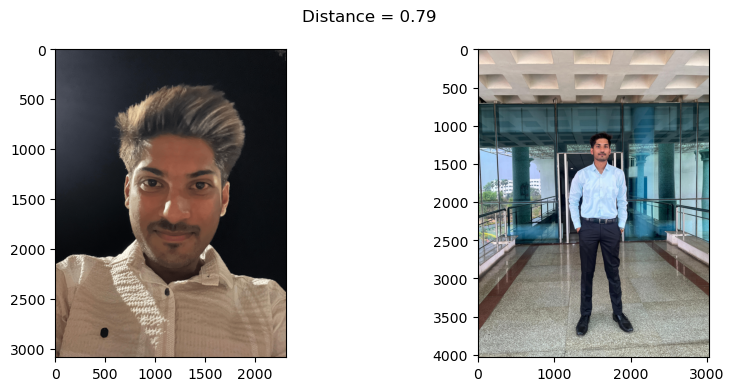

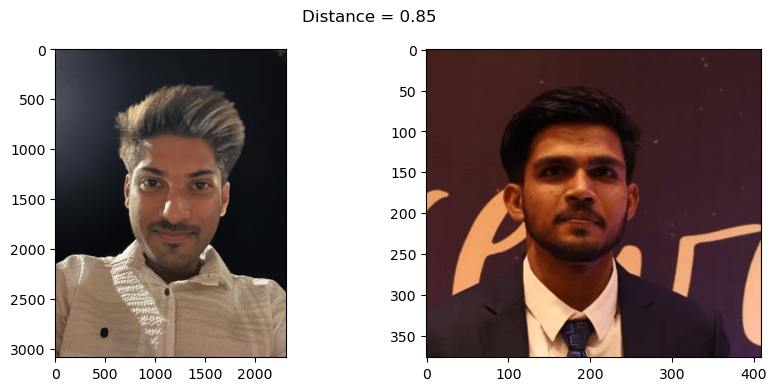

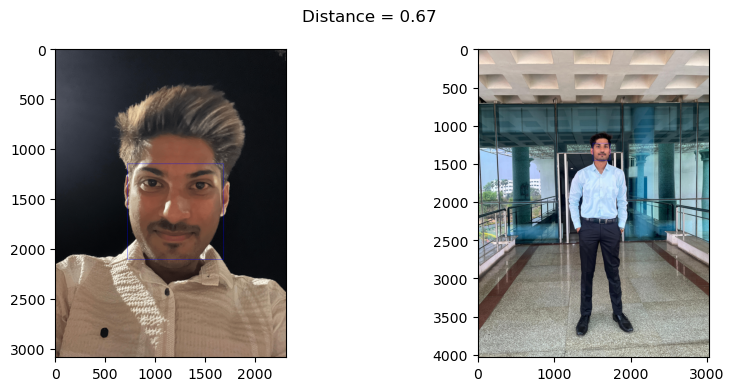

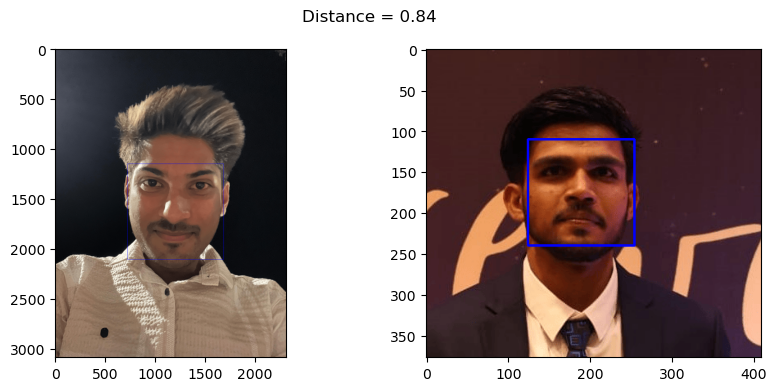

In [4]:
# ################### THE OPENFACE CNN ###################
# Load Openface model
FRmodel = faceRecoModel(input_shape=(3,96,96))
FRmodel.load_weights('Libraries/nn4.small2.v1.h5')
FRmodel.summary()

# Load image
anchor_path = 'Database/Udit_Sethi/Udit_001.png'
anchor_img = import_image(anchor_path)
pos_path = 'Database/Udit_Sethi/Udit_002.png'
pos_img = import_image(pos_path)
neg_path = 'Database/Sumit_Kumar/Sumit_003.png'
neg_img = import_image(neg_path)

# Embedding without face extraction
show_pair(anchor_img, pos_img, FRmodel, aligned=False)
show_pair(anchor_img, neg_img, FRmodel, aligned=False)

# Image embedding with face extraction
show_pair(anchor_img, pos_img, FRmodel, aligned=True)
show_pair(anchor_img, neg_img, FRmodel, aligned=True)

In [5]:
# Generate database
generate_database('Database', FRmodel, augmentations=3, output_name='friends.npy')      
face_dict = np.load('friends.npy', allow_pickle=True).item()

Total run time: 5573.39 ms


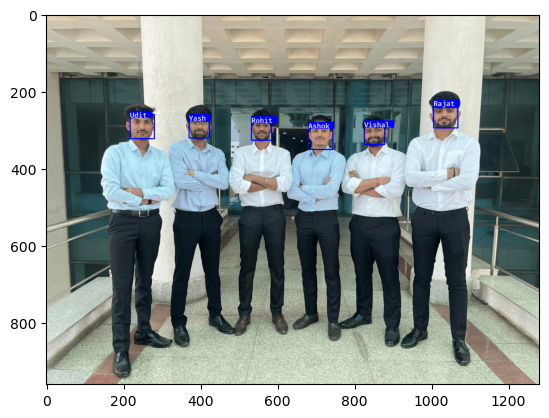

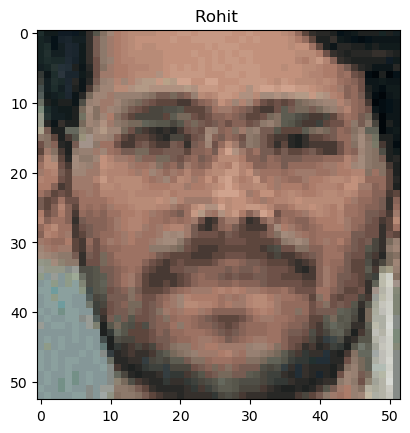

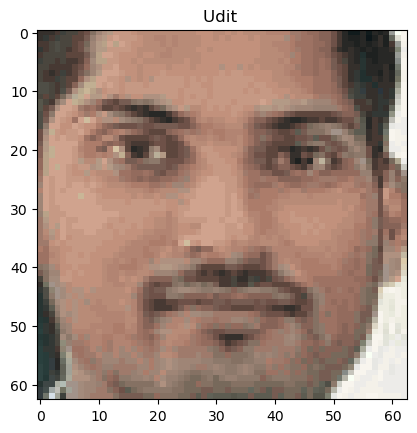

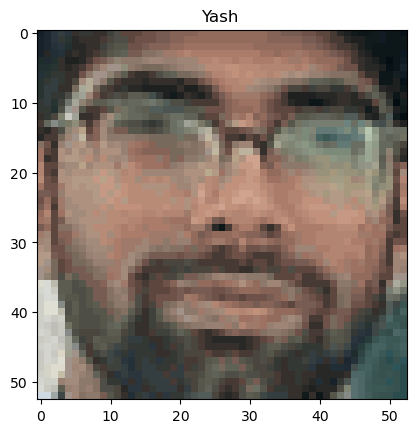

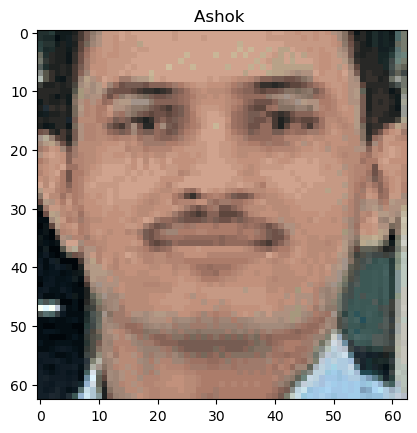

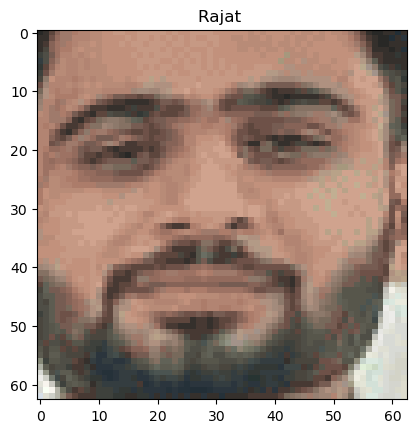

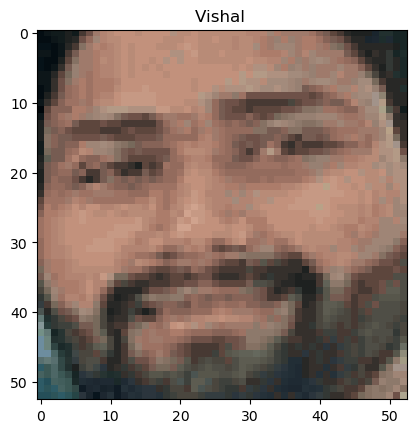

In [6]:
#################### FACE RECOGNITION #########################

#--------------- Face recognition on photo -------------------#
# Face detection
img_path = 'test.png' #Database/Friends/Minh_Thuong/Minh_Thuong_003.png'
image = import_image(img_path)
face_list, face_pos, img = get_faces_from_image(image, plot=True)

# Face recognition
time_start = time.time()
face_out = face_recognition(image, FRmodel, face_dict, plot=True, faces_out=True)
time_end = time.time()
print('Total run time: %.2f ms' %((time_end-time_start)*1.e3))

# Plot all identified face
for name in face_out.keys():
    this_face = face_out[name]
    fig = plt.figure()
    plt.imshow(this_face)
    plt.title(name)

In [ ]:
#------------------- Face recognition on webcam video--------------------#

video = cv2.VideoCapture(0)
# Capture continuously
a = 0
while True:
    a = a+1
    check, frame = video.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_show = face_recognition(frame, FRmodel, database=face_dict, plot=False)
    img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    cv2.imshow('Capturing', img_show)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    
video.release()


import gc
gc.collect()
K.clear_session()